# Classification of Image Data with Multilayer Perceptrons and Convolutional Neural Networks

## Installations

In [53]:
import medmnist
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
from medmnist import INFO, Evaluator
import numpy as np
print(medmnist.__version__)

3.0.2


## Task 1: Acquire the data / Investigate data

We utilize pytorch for the convienent dataloader format, as described in: 
    https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb   

NOTE: We must pre-process labels to be OHE

In [38]:
data_flag = 'organamnist'
download = True

BATCH_SIZE = 128 #We default this for the data loader
# lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [48]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

train_loader = data.DataLoader(dataset = train_dataset, batch_size= 128, shuffle = True)

Using downloaded and verified file: /home/sebastiancsabry/.medmnist/organamnist.npz
Using downloaded and verified file: /home/sebastiancsabry/.medmnist/organamnist.npz
Using downloaded and verified file: /home/sebastiancsabry/.medmnist/organamnist.npz


In [49]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset OrganAMNIST of size 28 (organamnist)
    Number of datapoints: 34561
    Root location: /home/sebastiancsabry/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left', '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'}
    Number of samples: {'train': 34561, 'val': 6491, 'test': 17778}
    Description: The OrganAMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Axial (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in axial views (planes). The images are resized into 1×28×28 to p

An example visulization:

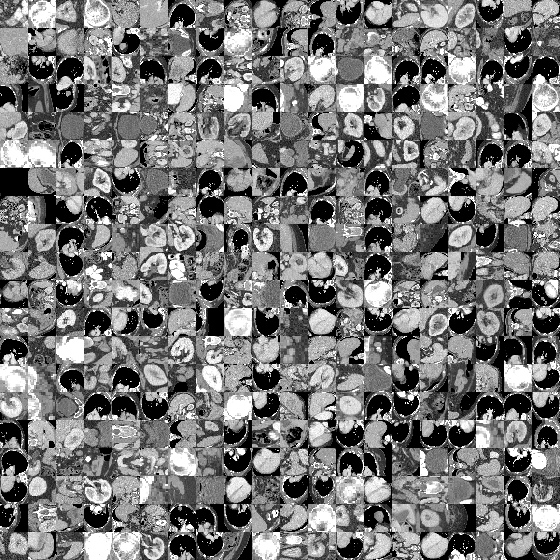

In [12]:
# montage
train_dataset.montage(length=20)

In [50]:
#Is this a correct intepretation?
print("Size of dataset: " + str(len(train_dataset)))
print("Size of vector: " + str(len(train_dataset[0])))
print("Channels: " + str(len(train_dataset[0][0])))
print("Matrix width: " + str(len(train_dataset[0][0][0][0])))
print("Matrix height: " + str(len(train_dataset[0][0][0])))

Size of dataset: 34561
Size of vector: 2
Channels: 1
Matrix width: 28
Matrix height: 28


In [51]:
for images, labels in train_loader:
    # `images` is a batch of image tensors
    # `labels` is a batch of corresponding labels
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    break  # Process just one batch for demonstration

Images shape: torch.Size([128, 1, 28, 28])
Labels shape: torch.Size([128, 1])


In [46]:
for images, labels in train_loader:
    for i in range(len(images)):
        # Extract individual datapoint
        datapoint = images[i]  # Shape: (1, 28, 28)
        label = labels[i]      # Scalar

        # Extract channels and image matrix
        channel = datapoint.shape[0]  # Should be 1 for grayscale
        image_matrix = datapoint[0]  # Shape: (28, 28), since only one channel
        
        print(f"Datapoint shape: {datapoint.shape}")
        print(f"Channel: {channel}")
        print(f"Image Matrix shape: {image_matrix.shape}")
        print(f"Label: {label}")
        break  # Process just one image for demonstration
    break

Datapoint shape: torch.Size([1, 28, 28])
Channel: 1
Image Matrix shape: torch.Size([28, 28])
Label: tensor([3])


# Task 2: Implement a Multilayer Perceptron

In [ ]:
'''HELPER FUNCTIONS'''
#(NXM)
def random_initalizer(n, m):
    return 0.01*np.random.randn(n, m)
#(NXM)
def relu_optimized_initalizer(n, m):
    return 0.01*np.random.randn(n, m) * Math.sqrt(2.0 / n)

def softmax(x, axis = None):
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

def ReLU(x):
    '''https://stackoverflow.com/questions/32109319/how-to-implement-the-relu-function-in-numpy'''
    return x * (x > 0)


In [ ]:
class ActivationFunction:
    """
    Dynamic class to handle activation functions and their derivatives
    """
def __init__(self, func, derivative):
        self.func = func
        self.derivative = derivative

def __call__(self, x):
    return self.func(x)

def grad(self, x):
    return self.derivative(x)

In [ ]:
class MLP: 
    CLASS_NUM = 11

    def __init__(self, initalizer, hidden_layers, hidden_units, activation_function, reguralization, normalization):
        self.initalizer = initalizer #function (e.g. random initialization)
        self.hidden_layers = hidden_layers #int (0 assumes we have just input layer)
        self.hidden_units = hidden_units #list[int, int, ...]
        self.activation_function = activation_function #function of activation class (e.g., ReLu)
        self.reguralization = reguralization #enum? (e.g. L2) Class structure?
        self.normalization = normalization #boolean (T/F)

        assert(hidden_layers == len(hidden_units))
        
        
    def fit(self, X, y, learning_rate):
        '''Fit method will call gradient descent. Assume batch size is called by data loader
            That is, we perform FGD on X. (We assume a static layer 0 to 2)'''
        N, D = X.shape
        #Initialization
        self.weights = []
        if self.hidden_layers == 0:
            w_x = self.initalizer(D, MLP.CLASS_NUM) #D x C
            self.weights.append(w_x)
            assert(len(self.weights) == 1)
        if self.hidden_layers == 1:
            w_h_x = self.initalizer(D, self.hidden_unit[0]) #D x Unit_1
            self.weights.append(w_h_x)
            w_y_h = self.initalizer(self.hidden_unit[0], MLP.CLASS_NUM) #Unit_1 x C
            self.weights.append(w_y_h)
            assert(len(self.weights) == 2)
        if self.hidden_layers == 2:
            w_h1_x = self.initalizer(D, self.hidden_unit[0]) #D x Unit_1
            self.weights.append(w_h1_x)
            w_h2_h1 = self.initalizer(self.hidden_unit[0], self.hidden_unit[1]) #Unit_1 x Unit_2
            self.weights.append(w_h2_h1)
            w_y_h2 = self.initalizer(self.hidden_unit[1], MLP.CLASS_NUM) #Unit_2 x C
            self.weights.append(w_y_h2)
            assert(len(self.weights) == 3)
         
        return None
    def gradient(self, X, y):
        '''
        Gradient Computation. We will assume that we have 0-2 layers (not including output layer or input) and do not need to write a dynamic gradient
        '''
        if self.hidden_layers == 0:
            #Forward
            yh = softmax(np.dot(X, self.weights[0])) #N x D,  D x C
            #Gradient
            dy = yh - y #N x C
            dw_0 = np.dot(dy, X.T) #N x C,  N x D
            return dw_0
        if self.hidden_layers == 1:
            #Forward
            a1 = np.dot(self.weights[0], X.T) #Unit_1xD DxN
            h_1 = self.activation_function(a1) #Unit_1xD DxN 
            a2 = np.dot(self.weights[1], h_1) #CxUnit_1 Unit_1xN
            yh = softmax(a2)
            #Gradient
            dy = yh - y #CxN
            W_h = self.weights[1] #CXUnit_1
            diagonal_activation = self.diagonal_matrix_derivative(a1, 
                self.activation_function.grad()) #Unit_1xD
            dw_h = np.dot(dy.T, h_1) #NxC 


            
    
    def diagonal_matrix_derivative(matrix, derivative_func):
        """
        Applies the derivative function to the diagonal of the input matrix.  
        As described in textbook: pg 439. 
        """
        
        result_matrix = np.zeros_like(matrix)

        
        n = min(matrix.shape[0], matrix.shape[1]) #non-square cases

        diagonal_indices = np.diag_indices(n)

        result_matrix[diagonal_indices] = derivative_func(matrix[diagonal_indices])

        return result_matrix
     
    
    '''Our cost function (softmax-cross-entropy) u is pre-activation before softmax'''
    def cost(self, X, y, u):
        yh = softmax(u)
        nll = - np.mean(np.sum(u*y) - torch.logsumexp(torch.tensor(u)))
        return nll

In [55]:
##Testing Block:
def diagonal_matrix_derivative(matrix, derivative_func):
    """
    Applies the derivative function to the diagonal of the input matrix.  
    As described in textbook: pg 439. 
    """
    
    result_matrix = np.zeros_like(matrix)

    
    n = min(matrix.shape[0], matrix.shape[1]) #non-square cases

    diagonal_indices = np.diag_indices(n)

    result_matrix[diagonal_indices] = derivative_func(matrix[diagonal_indices])

    return result_matrix

def derivative(x):
    return 2*x

matrix = np.array([[1,2,3],
                   [4,5,6]])

result = diagonal_matrix_derivative(matrix=matrix, derivative_func=derivative)

print(result)

[[ 2  0  0]
 [ 0 10  0]]
